Importamos todo

In [1]:
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.io import wavfile
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models
import os
import sys
import pathlib
import random
import librosa
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ALS_table = pd.read_excel('/content/drive/MyDrive/AplicacionesVoz/ALS_table.xlsx', converters={'Subject code':str})
ALS_codes = ALS_table.get('Subject code')
HC_table = pd.read_excel('/content/drive/MyDrive/AplicacionesVoz/HC_table.xlsx', converters={'Subject code':str})
HC_codes = HC_table.get('Subject code')
data_dirALS = str(pathlib.Path('/content/drive/MyDrive/AplicacionesVoz/ALS'))
data_dirHC = str(pathlib.Path('/content/drive/MyDrive/AplicacionesVoz/HC'))
filenamesALS = tf.io.gfile.glob(data_dirALS + '/*')
filenamesHC = tf.io.gfile.glob(data_dirHC + '/*')
dataset_X = []
spectrograms = []
dataset_Y = []
dataset = []
HC_dataset = []
filenames = []
filenames = np.append(filenames, filenamesALS)
filenames = np.append(filenames, filenamesHC)
classes = ['ALS', 'HC']
filenames.sort()

Funcion auxiliar para plotear

In [3]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Función auxiliar para obtener espectrograma

In [4]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Funcion auxiliar para obtener espectrogramas y sus etiquetas

In [5]:
def get_spectrogram_and_label(filepath):
  audioFile = tf.io.read_file(filepath)
  waveform = tf.audio.decode_wav(contents=audioFile, desired_samples=44100*3)
  waveform = tf.squeeze(waveform.audio, axis=-1)
  waveform = tf.cast(waveform, dtype=tf.float32)
  spectrogram = get_spectrogram(waveform)
  parts = tf.strings.split(
    input=filepath,
    sep=os.path.sep)
  label = tf.argmax(parts[-2] == classes)
  return spectrogram, label

Función auxiliar para sacar bandas mel

In [6]:
def get_mel_spectrogram(waveform):
  stfts = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrograms = tf.abs(stfts)
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20, 20000, 80
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix( num_mel_bins, num_spectrogram_bins, 44100.0, lower_edge_hertz, upper_edge_hertz)
  mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
  return mfccs

Funcion auxiliar para obtener bandas mel y la etiqueta

In [7]:
def get_mel_spectrogram_and_label(filepath):
  audioFile = tf.io.read_file(filepath)
  waveform = tf.audio.decode_wav(contents=audioFile, desired_samples=44100*3)
  waveform = tf.squeeze(waveform.audio, axis=-1)
  waveform = tf.cast(waveform, dtype=tf.float32)
  spectrogram = get_mel_spectrogram(waveform)
  parts = tf.strings.split(
    input=filepath,
    sep=os.path.sep)
  label = tf.argmax(parts[-2] == classes)
  return spectrogram, label

Ploteamos un espectrograma de ejemplo junto a su funcion de onda

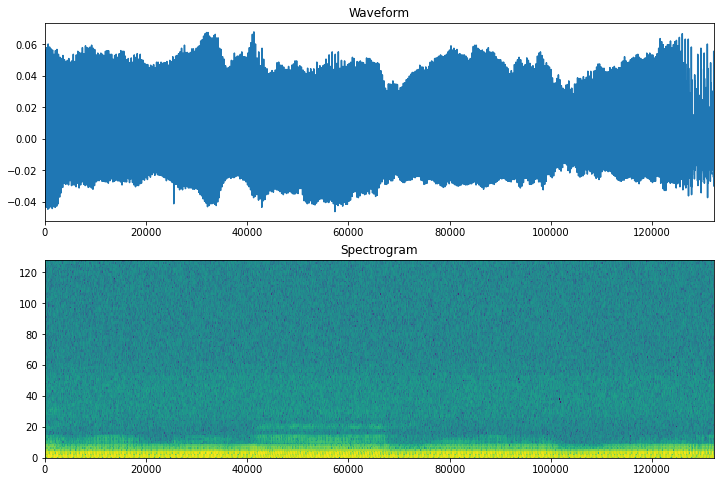

In [8]:
audioFile = tf.io.read_file('/content/drive/MyDrive/AplicacionesVoz/ALS/055_a.wav')
waveform = tf.audio.decode_wav(contents=audioFile, desired_samples=44100*3)
waveform = tf.squeeze(waveform.audio, axis=-1)
waveform = tf.cast(waveform, dtype=tf.float32)
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 44100*3])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[1].set_xlim([0, 44100*3])
plt.show()

Epoch 1/50
6/6 [==============================] - 25s 4s/step - loss: 43.0877 - accuracy: 0.6742 - val_loss: 30.2843 - val_accuracy: 0.7368
Epoch 2/50
6/6 [==============================] - 0s 85ms/step - loss: 24.2080 - accuracy: 0.7472 - val_loss: 15.8375 - val_accuracy: 0.8421
Epoch 3/50
6/6 [==============================] - 1s 87ms/step - loss: 12.7812 - accuracy: 0.8034 - val_loss: 9.2488 - val_accuracy: 0.8947
Epoch 4/50
6/6 [==============================] - 1s 92ms/step - loss: 8.7809 - accuracy: 0.7921 - val_loss: 7.3560 - val_accuracy: 0.8947
Epoch 5/50
6/6 [==============================] - 1s 84ms/step - loss: 6.4488 - accuracy: 0.8539 - val_loss: 4.8656 - val_accuracy: 0.8947
Epoch 6/50
6/6 [==============================] - 0s 85ms/step - loss: 4.4715 - accuracy: 0.8202 - val_loss: 3.8186 - val_accuracy: 0.8947
Epoch 7/50
6/6 [==============================] - 1s 90ms/step - loss: 3.5462 - accuracy: 0.8764 - val_loss: 2.9460 - val_accuracy: 0.8947
Epoch 8/50
6/6 [=======

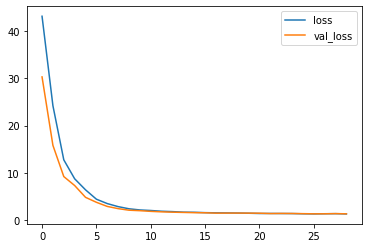

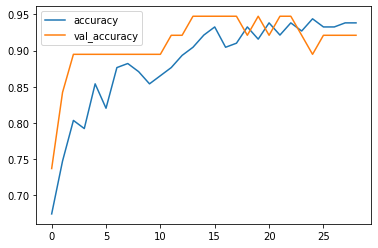

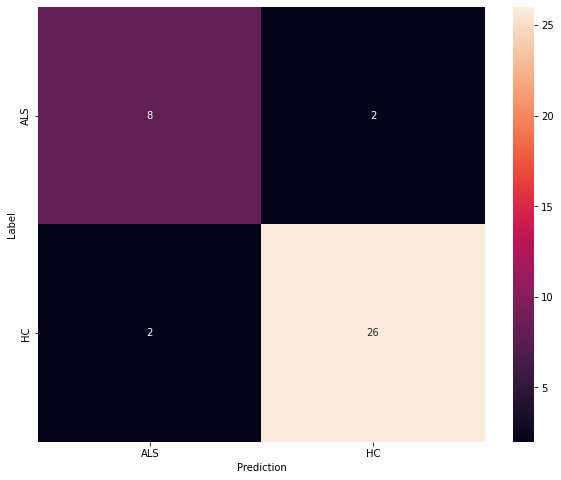

Epoch 1/50
6/6 [==============================] - 24s 4s/step - loss: 42.7779 - accuracy: 0.6404 - val_loss: 29.4524 - val_accuracy: 0.9211
Epoch 2/50
6/6 [==============================] - 1s 88ms/step - loss: 23.2870 - accuracy: 0.7921 - val_loss: 14.7520 - val_accuracy: 0.9474
Epoch 3/50
6/6 [==============================] - 0s 83ms/step - loss: 11.6770 - accuracy: 0.8371 - val_loss: 8.2046 - val_accuracy: 0.9211
Epoch 4/50
6/6 [==============================] - 0s 85ms/step - loss: 7.9257 - accuracy: 0.7921 - val_loss: 6.7739 - val_accuracy: 0.8684
Epoch 5/50
6/6 [==============================] - 1s 88ms/step - loss: 6.0396 - accuracy: 0.8820 - val_loss: 4.6362 - val_accuracy: 0.9211
Epoch 6/50
6/6 [==============================] - 0s 85ms/step - loss: 4.3710 - accuracy: 0.8258 - val_loss: 3.7245 - val_accuracy: 0.9474
Epoch 7/50
6/6 [==============================] - 1s 88ms/step - loss: 3.4706 - accuracy: 0.8933 - val_loss: 2.8910 - val_accuracy: 0.8684
Epoch 8/50
6/6 [=======

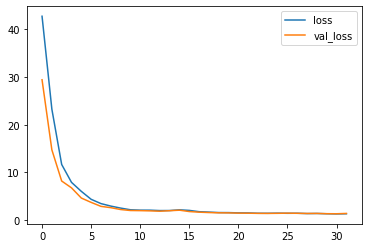

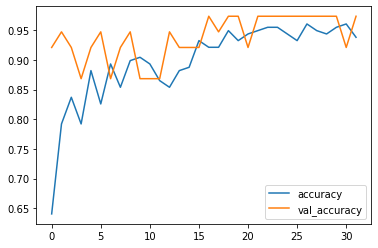

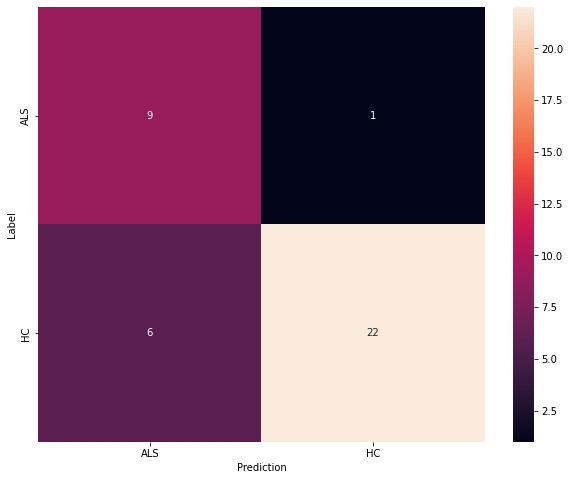

Average accuracy: 0.8552631578947368
Average accuracy ALS: 85.0
Average accuracy HC: 85.71428571428571


In [9]:
iteraciones = 2
EPOCHS = 50
sizeTrain = 178
sizeVal = 38
sizeTest = 254 - sizeTrain - sizeVal
average = []
aciertoALS = []
aciertoHC = []
for iteracion in range(iteraciones):
    contTrain = 0
    contVal = 0
    contTest = 0
    trainFiles = [0] * sizeTrain
    valFiles = [0] * sizeVal
    testFiles = [0] * sizeTest
    noAdd = False
    contTestALS = 0
    contValALS = 0
    contFile = 0
    addTrain = True
    addVal = True
    addTest = True
    i = 0
    while(i < len(filenames)):
        n = random.randint(0,2)
        if(n==0):
            if(contTrain<sizeTrain and addTrain):
                trainFiles[contTrain] = filenames[i] 
                trainFiles[contTrain+1] = filenames[i+1] 
                contTrain += 2
                if(contTrain > (sizeTrain/4)+2 and contFile < 66):
                    addTrain = False
            else:
                noAdd = True
        elif(n==1):
            if(contVal<sizeVal and addVal):
                valFiles[contVal] = filenames[i] 
                valFiles[contVal+1] = filenames[i+1] 
                contVal += 2
                if(contVal > sizeVal/4 and contFile < 66):
                    addVal = False
            else:
                noAdd = True
        elif(n==2):
            if(contTest<sizeTest and addTest):
                testFiles[contTest] = filenames[i] 
                testFiles[contTest+1] = filenames[i+1] 
                contTest += 2
                if(contTest > sizeTest/4 and contFile < 66):
                    addTest = False
            else:
                noAdd = True
        if(noAdd):
            if(contTrain<sizeTrain and addTrain):
                trainFiles[contTrain] = filenames[i] 
                trainFiles[contTrain+1] = filenames[i+1] 
                contTrain += 2
            elif(contVal<sizeVal and addTest):
                valFiles[contVal] = filenames[i] 
                valFiles[contVal+1] = filenames[i+1] 
                contVal += 2
            elif(contTest<sizeTest and addVal):
                testFiles[contTest] = filenames[i] 
                testFiles[contTest+1] = filenames[i+1] 
                contTest += 2
        noAdd = False
        i += 2
        contFile += 2
        if (contFile>66 and ((not addTrain) or (not addVal) or (not addTest))):
            addTrain = True
            addVal = True
            addTest = True
    trainFiles = tf.random.shuffle(trainFiles)
    testFiles = tf.random.shuffle(testFiles)
    valFiles = tf.random.shuffle(valFiles)
    AUTOTUNE = tf.data.AUTOTUNE
    # Train subdataset
    files_ds = tf.data.Dataset.from_tensor_slices(trainFiles)
    spectrogram_ds = files_ds.map(map_func=get_mel_spectrogram_and_label,num_parallel_calls=AUTOTUNE)
    # Test subdataset
    files_ds = tf.data.Dataset.from_tensor_slices(testFiles)
    test_ds = files_ds.map(map_func=get_mel_spectrogram_and_label,num_parallel_calls=AUTOTUNE)
    # Validation subdataset
    files_ds = tf.data.Dataset.from_tensor_slices(valFiles)
    val_ds = files_ds.map(map_func=get_mel_spectrogram_and_label,num_parallel_calls=AUTOTUNE)
    train_ds = spectrogram_ds
    train_ds = train_ds.batch(32)
    val_ds = val_ds.batch(32)
    #Implementamos cache para reducir latencia
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    for spectrogram, label in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
    model = models.Sequential([
        layers.Input(shape=input_shape),
        norm_layer,
        layers.Conv1D(8, 3, activation='relu', kernel_regularizer='l2'),
        layers.Conv1D(16, 3, activation='relu', kernel_regularizer='l2'),
        layers.Conv1D(32, 3, activation='relu', kernel_regularizer='l2'),
        layers.MaxPooling1D(),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(32, activation='relu', kernel_regularizer='l1'),
        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.Dropout(0.6),
        layers.Dense(2),
    ])
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    )
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=15),
    )
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    y_pred = np.argmax(model.predict(test_audio), axis=1)
    y_true = test_labels

    test_acc = sum(y_pred == y_true) / len(y_true)
    average.append(test_acc)
    print(f'Test set accuracy: {test_acc:.0%}')
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()
    plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    matriz = confusion_mtx.numpy()
    aciertoALS.append(matriz[0][0])
    aciertoHC.append(matriz[1][1])
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx,
    xticklabels=classes,
    yticklabels=classes,
    annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
print('Average accuracy:' , np.mean(np.array(average)))
print('Average accuracy ALS:', np.mean(aciertoALS)*10)
print('Average accuracy HC:', ((np.sum(aciertoHC)/iteraciones)/28)*100)